Cleaning Data for Analysis 

In [1]:
#import statements
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error

In [2]:
#function definitions
def PlotScatter(yhat):
    fig, ax = plt.subplots()
    ax.scatter(yhat, yTest)
    ax.set_xlabel('Predicted Sale Price (in Millions)')
    ax.set_ylabel('Actual Sale Price (in Millions)')
    return ax

Because not all new construction homes were sold, and among those that were sold, not all reported the sale price. Those cases simply list sale price (SLPR) as 0. Because for our analysis these examples are not of interest to us they will be removed. Additionally there are two variables that indicate the sale price of the home: SLPR and FSLPR. FSLPR (Final Sale Price) is only filled in if the SLPR was changed before the final closing date. Because we would like the most accurate information FSLPR and SLPR will be combined into FSLPR filling in the missing information of FSLPR with SLPR.

In [30]:
## Reading and cleaning data
raw_data = pd.read_csv('soc19.csv')
print(raw_data.shape)

## Remove rows where sale price was not reported or house was not sold 
raw_data = raw_data[(raw_data['SLPR'] != 0) | (raw_data['FSLPR'] != 0)]

## If FSLPR is zero, replace this value with SLPR
zeroFSLPR = raw_data.FSLPR == 0
raw_data.FSLPR[zeroFSLPR] = raw_data.SLPR[zeroFSLPR]

## Merge SQFS and FSQFS
zeroFSQFS = raw_data.FSQFS == 0
nonZeroFSQFS = np.invert(zeroFSQFS)
meanFSQFS = np.mean(raw_data.FSQFS[nonZeroFSQFS])
raw_data.FSQFS[zeroFSQFS] = raw_data.SQFS[zeroFSQFS]

#if the final square foot is zero replace with mean
zeroFSQFS = raw_data.FSQFS == 0
raw_data.FSQFS[zeroFSQFS] = meanFSQFS

## Impute values of LOTV with mean
zeroLOTV = raw_data.LOTV == 0
nonZeroLOTV = np.invert(zeroLOTV)
meanLORV = np.mean(raw_data.FSQFS[nonZeroLOTV])

raw_data.LOTV[zeroLOTV] = meanLORV

## Impute values of AREA with mean
zeroAREA = raw_data.AREA == 0
nonZeroAREA = np.invert(zeroAREA)
meanAREA = np.mean(raw_data.FSQFS[nonZeroAREA])
raw_data.AREA[zeroAREA] = meanAREA

## Features to remove 
remove_features = ["SLPR", "FCONPR", "SALE", "COMP", "AUTH", "ID", "STRT", "PVALU", "FNSQ_F", "CONPR", "FINC",
               "SLPR_F", "FSLPR_F", "FCONPR_F", "LOTV_F", "SQFS_F", "FSQFS_F", "PVALU_F", "AREA_F", "CONPR_F", "SQFS"]

## Removing Features 
raw_data = raw_data.drop(columns = remove_features)
 
# clean data export
cleaned_data = raw_data 
raw_data.to_csv('cleaned_data.csv', index = False)
print(cleaned_data.shape)

## Creating a data dictionary to specify data types 
feature_types = {"ACS": 'category', "AGER": 'category', "ASSOC": 'category', "BASE": 'category',
                "CAT": 'category', "CLOS": 'category', "CON": 'category', "DECK": 'category',
                "DET": 'category', "DIV": 'category', "FNBS": 'category', "FOYER": 'category',
                "FRAME": 'category', "GAR": 'category', "HEAT": 'category', "HEAT2": 'category',
                "LNDR": 'category', "MFGS": 'category', "PATI": 'category', "PRCH": 'category',
                "SEWER": 'category', "STOR": 'category', "WAL1": 'category', "WALS": 'category',
                "WATER": 'category', "BEDR": 'category', "FPLS": 'category', "FULB": 'category',
                "HAFB": 'category', "WEIGHT": int, "FUEL": 'category', "FUEL2": 'category',
                "FSLPR": np.float64, "FSQFS": np.float64, "LOTV": np.float64,
                "FFNSQ": np.float64, "AREA": np.float64}

## Changing data types of features
cleaned_data = cleaned_data.astype(feature_types)

#create train and test set
x = cleaned_data.loc[:, cleaned_data.columns != 'FSLPR']
y = cleaned_data.loc[:, cleaned_data.columns == 'FSLPR']
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.2, random_state = 1)

## Create 1d arrays of training and test sample weights 
training_weights = xTrain.loc[:, xTrain.columns == 'WEIGHT'].values.flatten()
testing_weights = xTest.loc[:, xTest.columns == 'WEIGHT'].values.flatten()

## Drop sample weights from training and testing data sets so not included in model
xTrain = xTrain.drop(columns = 'WEIGHT')
xTest = xTest.drop(columns = 'WEIGHT')



(24810, 61)
(13257, 40)


General Data Exploration: Stats stuff not necessarily related to machine learning

In [31]:
#summary statistics
cleaned_data['FSLPR'].describe()

count    1.325700e+04
mean     2.005048e+05
std      2.162092e+05
min      2.590449e+03
25%      3.571842e+04
50%      3.571842e+04
75%      3.250000e+05
max      2.229000e+06
Name: FSLPR, dtype: float64

Text(0.5, 1.0, 'Distribution of Final Sale Price')

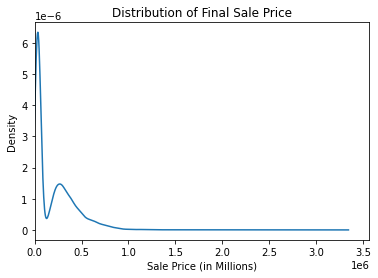

In [32]:
FSLPRdensity = cleaned_data['FSLPR'].plot(kind = 'density')
FSLPRdensity.set_xlabel('Sale Price (in Millions)')
FSLPRdensity.set_xlim(0)
FSLPRdensity.set_title('Distribution of Final Sale Price')

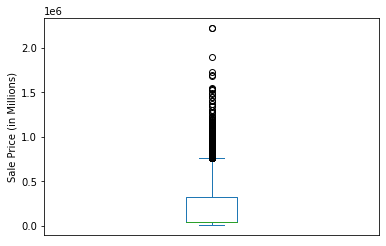

In [33]:
FSLPRbox = cleaned_data['FSLPR'].plot(kind = 'box') #lot of high outliers
FSLPRbox.set_ylabel('Sale Price (in Millions)')
FSLPRbox.xaxis.set_visible(False)

Text(0, 0.5, 'Sale Price')

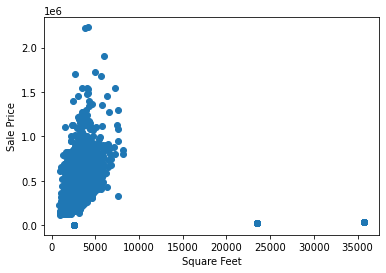

In [34]:
#Examining relationship of important predictors with final sale price

plt.scatter(cleaned_data['FSQFS'], cleaned_data['FSLPR']) #A lot of square footage recorded as zero in the data set. Likely an error in data entry that shouldve been an NA
plt.xlabel('Square Feet')
plt.ylabel('Sale Price')

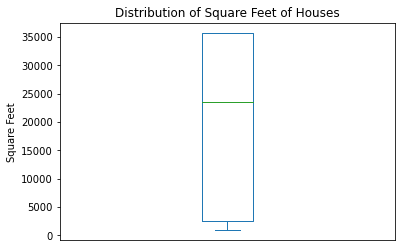

In [35]:
box = cleaned_data['FSQFS'].plot(kind = 'box')
box.set_ylabel('Square Feet')
box.set_title('Distribution of Square Feet of Houses')
box.xaxis.set_visible(False)

number of zeros for square feet: 0


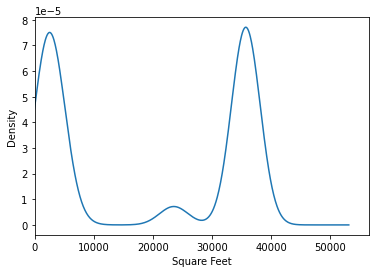

In [36]:
 #Lot of zeros in the data set for square feet
density = cleaned_data['FSQFS'].plot(kind = 'density')
density.set_xlabel('Square Feet')
density.set_xlim(0)

print('number of zeros for square feet:', len(cleaned_data.FSQFS) - np.count_nonzero(cleaned_data.FSQFS))

ValueError: shape mismatch: objects cannot be broadcast to a single shape

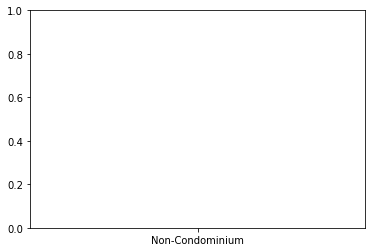

In [37]:
con = cleaned_data['CON'].value_counts()[:-1]
levels = ['Non-Condominium', 'Condominium']
plt.bar(levels, con)
plt.ylabel('Count')
plt.title('Type of Housing')

ValueError: shape mismatch: objects cannot be broadcast to a single shape

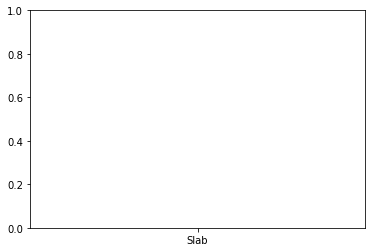

In [38]:
base = cleaned_data['BASE'].value_counts()
levels = ['Slab', 'Basement', 'Crawl Space', 'Other', 'NA']
plt.bar(levels, base)
plt.ylabel('Count')
plt.title('Distribution of Foundation Type')

Model Implementation

In [31]:
## Simple linear regression as baseline 
reg = LinearRegression()
reg.fit(xTrain, yTrain,
        sample_weight = training_weights)

LinearRegression()

In [32]:
## Asses linear regression model
yHatReg = reg.predict(xTest)
score_reg = reg.score(xTest, yTest,
                      sample_weight = testing_weights)
print('Coefficient of determination on test set:', np.round(score_reg,2))
print('MSE:', mean_squared_error(yTest, yHatReg, sample_weight= testing_weights))

Coefficient of determination on test set: 0.47
MSE: 22775798782.922092


In [33]:
#Random Forest
rForest = RandomForestRegressor(n_estimators=500)

# hyper-parameter optimization was run with the following grid search layout
# I have commented it out and changed the main regressor to reflect the best parameters to save time

# params = {
#        'n_estimators': [100, 250, 500, 1000],
# }

# gridForest = GridSearchCV(estimator = rForest, param_grid = params, n_jobs = -1)
# gridForest.fit(xTrain, yTrain.values.ravel(), sample_weight = training_weights)
# print('best parameters:', gridForest.best_params_)

rForest.fit(xTrain, yTrain.values.ravel(), sample_weight = training_weights)

RandomForestRegressor(n_estimators=500)

In [34]:
#evaluate model in another cell so don't need to refit model every time
yHatForest = rForest.predict(xTest)
scoreForest = rForest.score(xTest, yTest, sample_weight = testing_weights)
print('Coefficient of determination on test set:', np.round(scoreForest,2)) 
print('MSE:', mean_squared_error(yTest, yHatForest, sample_weight = testing_weights))
#PlotScatter(yHatForest)

Coefficient of determination on test set: 0.79
MSE: 9186289282.67023


In [35]:
#train decision tree
tree = DecisionTreeRegressor(criterion = 'friedman_mse',
                            max_depth = 10,
                            min_samples_split = 10,
                            random_state = 1)
# params = {
#        'criterion': ['squared_error', 'friedman_mse'],
#        'splitter': ['best', 'random'],
#        'max_depth': [5, 10, 15, None],
#        'min_samples_split': [2, 5, 10],
#        'max_features': ['auto', 'sqrt', 'log2'],
#        'random_state': [1]

# }

# gridTree = GridSearchCV(estimator = tree, param_grid = params, n_jobs = -1)
# gridTree.fit(xTrain, yTrain.values.ravel(), sample_weight = training_weights)
# print('best parameters:', gridTree.best_params_)
# print('best score', gridTree.best_score_)

tree.fit(xTrain, yTrain, sample_weight = training_weights)

DecisionTreeRegressor(criterion='friedman_mse', max_depth=10,
                      min_samples_split=10, random_state=1)

In [36]:
#assess tree
yHatTree = tree.predict(xTest)
scoreTree = tree.score(xTest, yTest, sample_weight = testing_weights)
print('coefficient of determination on test set:', np.round(scoreTree,2))
print('MSE:', mean_squared_error(yTest, yHatTree, sample_weight = testing_weights))
#PlotScatter(yHatTree)

coefficient of determination on test set: 0.66
MSE: 14788106629.111477


Gradient Boosting Model

In [37]:
#Gradient boosting 
GBR = GradientBoostingRegressor(n_estimators = 500, max_depth = 5)

# hyper-parameter optimization was run with the following grid search layout
# I have commented it out and changed the main regressor to reflect the best parameters to save time

# params = {
#        'learning_rate': [0.01, 0.05, 0.1, 0.2], 
#        'n_estimators': [100, 250, 500, 1000],
#        'max_depth': [1, 2, 3, 4, 5, 10]     
# }

# gridGBR = GridSearchCV(estimator = GBR, param_grid = params, n_jobs = -1)
# gridGBR.fit(xTrain, yTrain.values.ravel(), sample_weight = training_weights)
# print('best parameters:', gridGBR.best_params_)

GBR.fit(xTrain, yTrain.values.ravel(), sample_weight = training_weights)


GradientBoostingRegressor(max_depth=5, n_estimators=500)

In [38]:
#assess gradient boosting model
yHatGBR = GBR.predict(xTest)
scoreGBR = GBR.score(xTest, yTest, sample_weight = testing_weights)
print('coefficient of determination on test set:', np.round(scoreGBR, 2))
print('MSE:', mean_squared_error(yTest, yHatGBR, sample_weight = testing_weights))
#PlotScatter(yHatGBR)

coefficient of determination on test set: 0.78
MSE: 9300942419.73888


In [47]:
## Training a stacking estimator 
estimators = [('rf', rForest),
              ('dc', tree),
              ('gb', GBR)]

stack_reg = StackingRegressor(estimators=estimators, 
                             final_estimator=RandomForestRegressor(n_estimators=100,
                                           random_state=1))
stack_reg.fit(xTrain, yTrain.values.ravel(),
        sample_weight = training_weights)


StackingRegressor(estimators=[('rf', RandomForestRegressor(n_estimators=500)),
                              ('dc',
                               DecisionTreeRegressor(criterion='friedman_mse',
                                                     max_depth=10,
                                                     min_samples_split=10,
                                                     random_state=1)),
                              ('gb',
                               GradientBoostingRegressor(max_depth=5,
                                                         n_estimators=500))],
                  final_estimator=RandomForestRegressor(random_state=1))

In [48]:
## Asses the stacking estimator 
yHatStack = stack_reg.predict(xTest)
score_stack = stack_reg.score(xTest, yTest, sample_weight = testing_weights)
print('coefficient of determination on test set:', np.round(score_stack,2))
print('MSE:', mean_squared_error(yTest, yHatStack, sample_weight = testing_weights))

coefficient of determination on test set: 0.97
MSE: 9315654.424497878


In [39]:
bag = BaggingRegressor(base_estimator = tree, n_estimators = 500, n_jobs = -1, random_state = 1)

# params = {'base_estimator': [tree, None], 
#         'n_estimators': [10, 100, 250, 500]}

# gridBag = GridSearchCV(estimator = bag, 
#                     param_grid = params,
#                     n_jobs = -1)

# gridBag.fit(xTrain, yTrain.values.ravel(), sample_weight = training_weights)
# print('best params:' , gridBag.best_params_)
# print('best_score:', gridBag.best_score_)

bag.fit(xTrain, yTrain.values.ravel(), sample_weight = training_weights)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='friedman_mse',
                                                      max_depth=10,
                                                      min_samples_split=10,
                                                      random_state=1),
                 n_estimators=500, n_jobs=-1, random_state=1)

In [40]:
yHatBag = bag.predict(xTest)
score_bag = bag.score(xTest, yTest, sample_weight = testing_weights)
print('coefficient of determination on test set:', np.round(score_bag, 2))
print('MSE:', mean_squared_error(yTest, yHatBag, sample_weight = testing_weights))

coefficient of determination on test set: 0.75
MSE: 10760906022.722229
